# Make Figures for Model Validation: Multi Cycles

5/9/2023

Andrew Weng

In [1]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

from src import cellsim as cellsim 

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from src import plotter as plotter

%load_ext autoreload

# Load the Experimental Data

In [14]:
plotter.initialize(plt, style='ieee')
target_dir = os.getcwd()
target_dir_arbin = f'{target_dir}/data/raw/from-voltaiq'

# To make the dQ/dV plot work, be sure to only select the FORM protocol without 
# including the aging file. Otherwise the time vector will be confused.
file_indices_to_include = np.array([1,2,3])

cellid = 152064

if cellid == 152064:
    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                    ]

    daq_channel = 'Key_CH1'

    hr_max = 60*24

elif cellid == 152074: # BASELINE FORMATION (repeat 2)
    
    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
                    ]

    daq_channel = 'Key_CH0'

    hr_max = 20*24

# Load the Arbin Data
df_arbin_list = []

for file in np.array(file_arbin_list)[file_indices_to_include]:

    df = pd.read_csv(file)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp']= df['Timestamp'].apply(lambda x : x.tz_localize(None))
    df_arbin_list.append(df)

df_arbin = pd.concat(df_arbin_list, axis=0)

# Filter the Arbin Data
ii = df_arbin['Current (A)']
qq = df_arbin['Charge Capacity (Ah)']
tv = df_arbin['Timestamp'].astype(int)
tv = (tv - np.min(tv)) / 1e9
y_voltage = df_arbin['Potential (V)']

y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN

# Load the Keyence data
file_keyence = f'{target_dir}/data/raw/from-keyence/keyence_20220901_213928.csv'
df_keyence = pd.read_csv(file_keyence)
df_keyence['computer time'] = pd.to_datetime(df_keyence['computer time'], unit='s')
df_keyence['computer time'] = df_keyence['computer time'].apply(lambda x : x.tz_localize(None))

# Filter the Keyence data
df_keyence = df_keyence.loc[(df_keyence['computer time'] > df_arbin['Timestamp'].iloc[0]) & \
                            (df_keyence['computer time'] < df_arbin['Timestamp'].iloc[-1])]
y_strain = df_keyence[daq_channel] - df_keyence[daq_channel].iloc[0]
# y_strain[y_strain > 500] = np.NaN

tt = df_keyence['computer time'].astype(int)
tt = (tt - np.min(tt)) / 1e9

y_strain.iloc[np.where(tt/3600 > hr_max)] = np.NaN

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_20613/140777446.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN


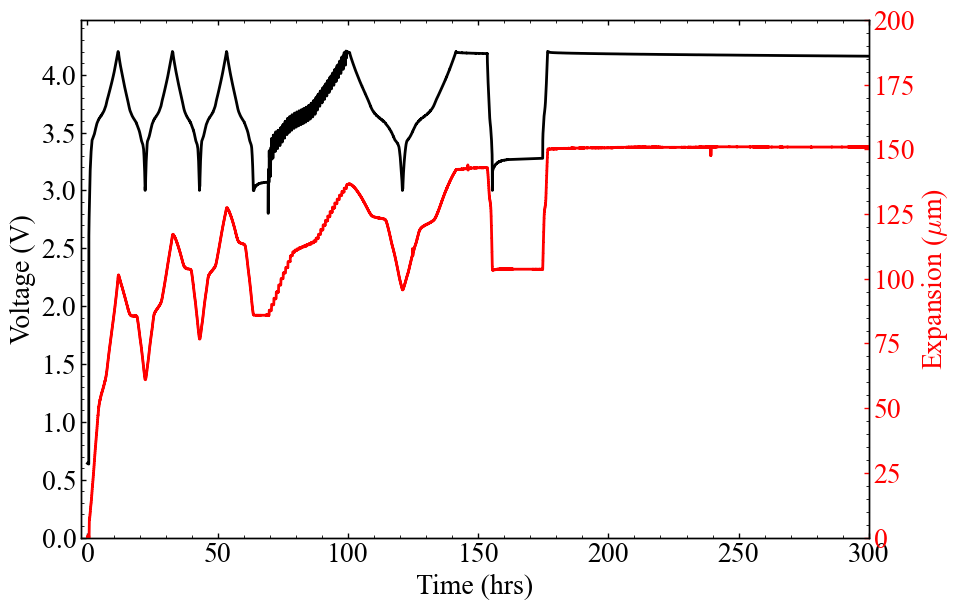

In [15]:
plt.figure(figsize=(10,6.5))

# The voltage plot
ax1 = plt.subplot()
ax1.plot(tv/3600, y_voltage, color='k')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Voltage (V)')
ax1.set_ylim(bottom=0)
ax1.grid(False)
# ax1.set_xlim((-0.1 * 24, 800))
ax1.set_xlim((-0.1 * 24, 300))

# The expansion plot
ax2 = ax1.twinx()
ax2.plot(tt/3600, y_strain, color='r')
ax2.set_ylabel(r'Expansion ($\mu$m)')
ax2.tick_params(axis='y', colors='r')
ax2.yaxis.label.set_color('red')
ax2.set_ylim(bottom=0, top=200)
ax2.grid(False)

plt.savefig(f'outputs/figures/fig_strain_vs_voltage_cell{cellid}.png', dpi=300)

# Run the simulation

In [16]:
%autoreload 
Ichg = 2.5/10  # A
Idch = -2.5/10 # A
Icv = 2.5/20   # A

vmax = 4.2
vmin = 3.0

cell = cellsim.Cell()
cell.load_config('params/default.yaml')
tag = cell.get_tag()

# sim = cellsim.Simulation(cell, 520*3600)
sim = cellsim.Simulation(cell, 24*20*3600)

# Formation
import time
sim.run_rest(1, rest_time_hrs=0.5)
sim.run_chg_cccv(2, 2.5/10, Icv, vmax)
sim.run_dch_cccv(2, Idch, Idch, vmin)
sim.run_chg_cccv(3, 2.5/10, Icv, vmax)
sim.run_dch_cccv(3, Idch, Idch, vmin)
sim.run_chg_cccv(4, 2.5/10, Icv, vmax)
sim.run_dch_cccv(4, Idch, Idch, vmin)
sim.run_rest(4, rest_time_hrs=6)

# RPT
sim.run_chg_cccv(5, +2.5/30, +2.5/30, vmax) # Approximate HPPC Pulse Charge
sim.run_dch_cccv(5, -2.5/20, Icv, vmin)
sim.run_chg_cccv(6, +2.5/20, Icv, vmax)
sim.run_rest(6, rest_time_hrs=14)
sim.run_dch_cccv(7, -2.5/2, -2.5/2, vmin) 
sim.run_rest(7, rest_time_hrs=19)

# Aging
sim.run_chg_cccv(8, 2.5/2, 2.5/2, vmax)
sim.run_rest(8, rest_time_hrs=7*24)
sim.run_dch_cccv(8, -2.5/20, -2.5/20, vmin)

df_sim = sim.get_results()

Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...
Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc4: Rest for 6 hours...
Running Cyc5: Charge to 4.2V...
Running Cyc5: Discharge to 3.0V...
Running Cyc6: Charge to 4.2V...
Running Cyc6: Rest for 14 hours...
Running Cyc7: Discharge to 3.0V...
Running Cyc7: Rest for 19 hours...
Running Cyc8: Charge to 4.2V...
Running Cyc8: Rest for 168 hours...
Running Cyc8: Discharge to 3.0V...


/Users/aweng/code/formation-modeling/src/cellsim.py:900: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  bbox_inches='tight',
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


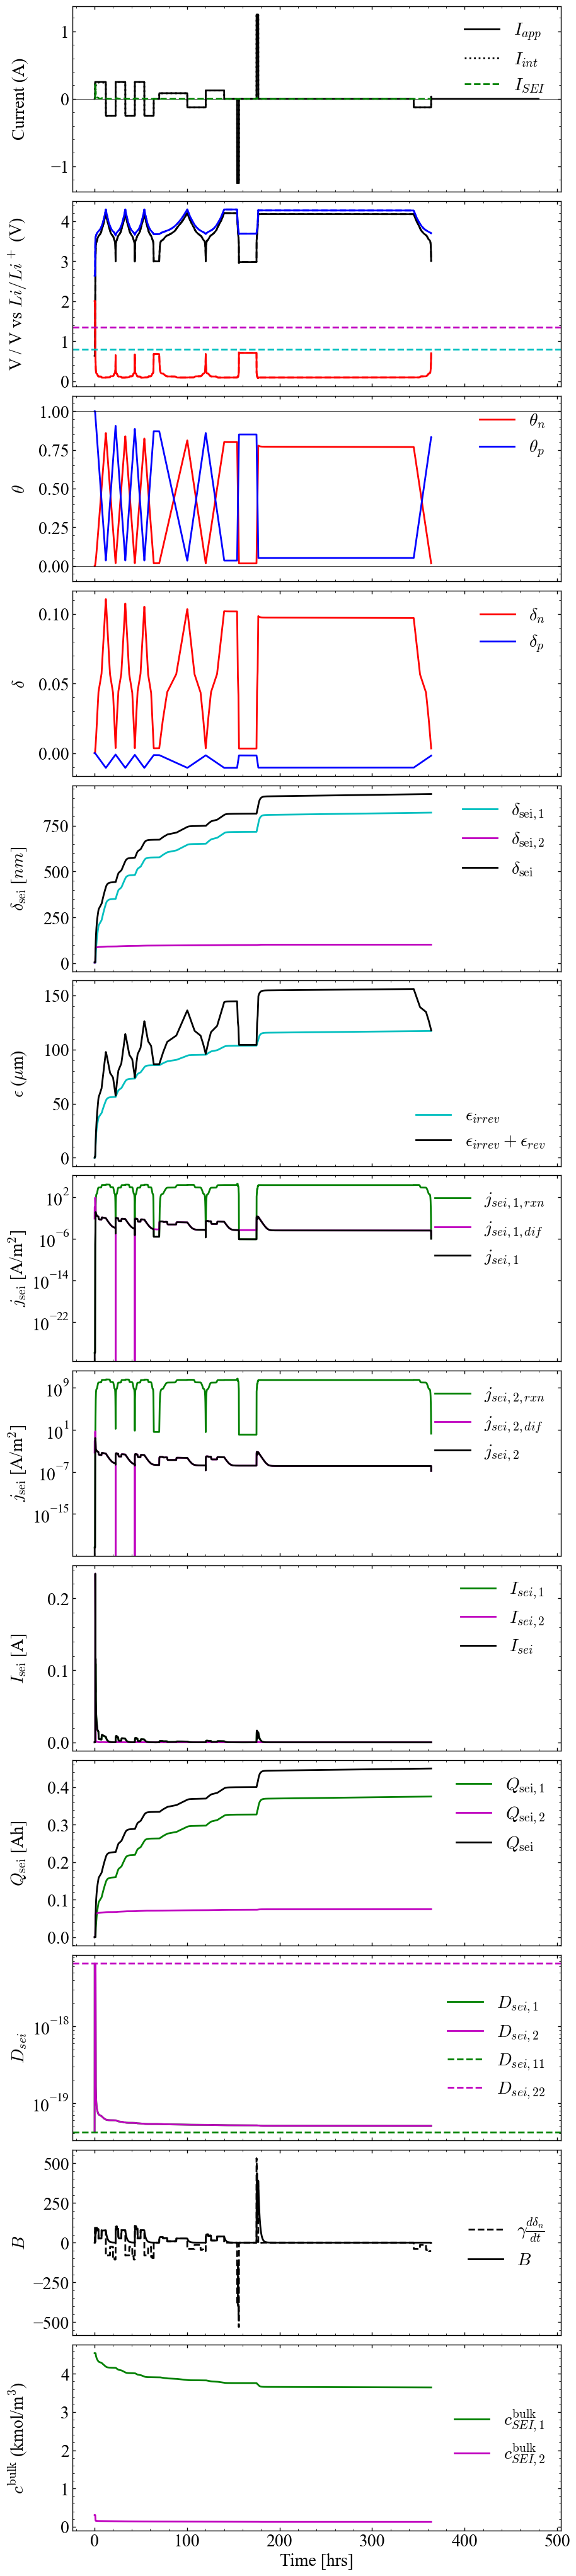

In [17]:
# %matplotlib widget
%autoreload
sim.plot()

# Compare Voltages

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_20613/1754107709.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'outputs/figures/fig_validation_{tag}.tif', dpi=200)


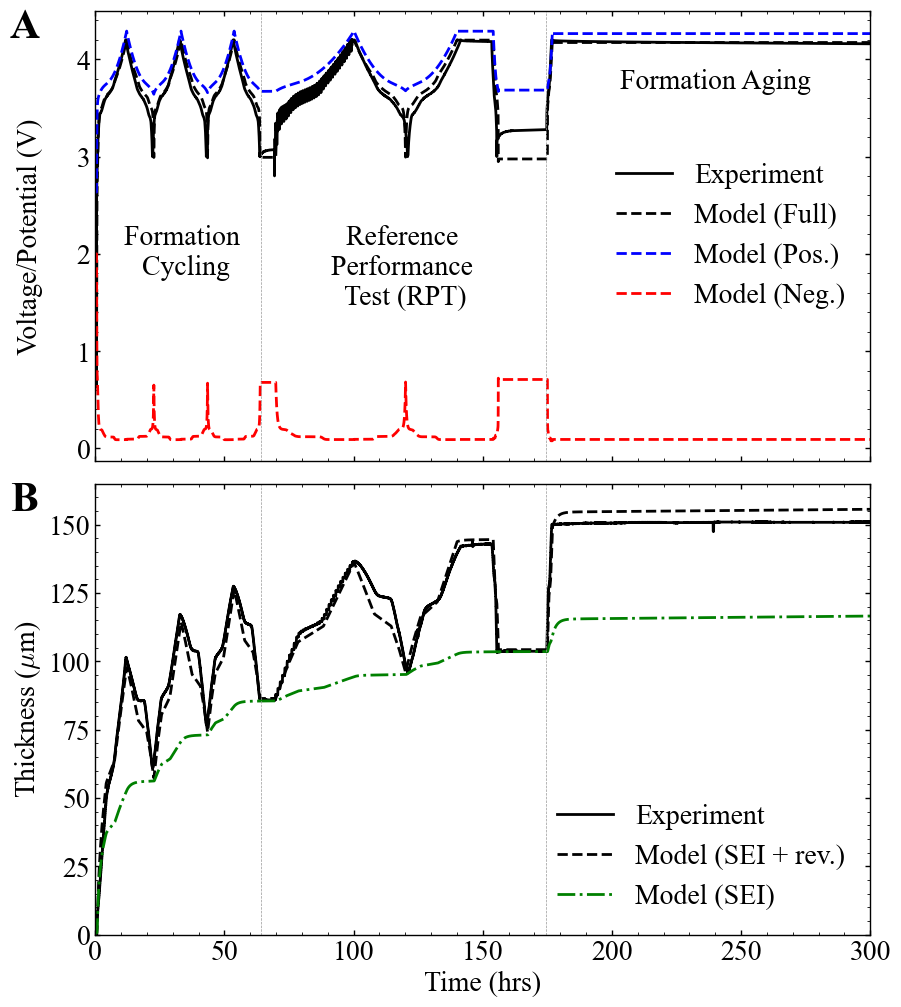

In [19]:
exp_sim = df_sim['expansion_rev'] + df_sim['expansion_irrev']
v_sim = df_sim['vt']
t_sim = df_sim['t']

gridspec = dict(hspace=0.05, height_ratios=[1,1])

fig, axs = plt.subplots(nrows=2, ncols=1,
                        figsize=(10,12),
                        gridspec_kw=gridspec,
                        sharex=True)

axs[0].grid(False)
axs[0].plot(tv/3600, y_voltage, c='k', lw=2, label='Experiment')
axs[0].plot(t_sim/3600, df_sim['vt'], c='k', ls='--', lw=2, label='Model (Full)')
axs[0].plot(t_sim/3600, df_sim['ocv_p'] + df_sim['eta_p'], c='b', ls='--', lw=2, label='Model (Pos.)')
axs[0].plot(t_sim/3600, df_sim['ocv_n'] - df_sim['eta_n'], c='r', ls='--', lw=2, label='Model (Neg.)')
axs[0].legend(loc='right', fontsize=20)
# axs[0].set_xlabel('Time (hrs)')
axs[0].set_ylabel('Voltage/Potential [V]')
axs[0].set_xlim((0, 300))

axs[1].grid(False)
axs[1].plot(tt/3600, y_strain, c='k', lw=2, label='Experiment')
axs[1].plot(t_sim/3600, (df_sim['expansion_rev'] + df_sim['expansion_irrev'])*1e6, c='k', lw=2, ls='--', label='Model (SEI + rev.)')
axs[1].plot(t_sim/3600, (df_sim['expansion_irrev'])*1e6, c='g', ls='-.', lw=2, label='Model (SEI)')
axs[1].legend(loc='lower right', fontsize=20)
axs[1].set_xlabel('Time [hrs]')
axs[1].set_ylabel('Thickness [$\mu$m]')
axs[1].set_ylim((0, 165))
axs[1].set_xlim((0, 300))

# Add guidelines
[ax.axvline(x=64.35, c=(0.6, 0.6, 0.6), linestyle='--', linewidth=0.5) for ax in axs]
[ax.axvline(x=174.5, c=(0.6, 0.6, 0.6), linestyle='--', linewidth=0.5) for ax in axs]

# Add text
axs[0].text(35, 2.3, 'Formation \nCycling', horizontalalignment='center', verticalalignment='top')
axs[0].text(120, 2.3, 'Reference \nPerformance \nTest (RPT)', horizontalalignment='center', verticalalignment='top')
axs[0].text(240, 3.7, 'Formation Aging', horizontalalignment='center')

# Add subplot identifers
axs[0].text(-0.11, 0.94, 'A', transform=axs[0].transAxes, fontsize=30, fontweight='bold')
axs[1].text(-0.11, 0.94, 'B', transform=axs[1].transAxes, fontsize=30, fontweight='bold')

fig.align_ylabels()

plt.savefig(f'outputs/figures/fig_validation_{tag}.tif', dpi=200)